In [1]:
import sys
sys.path.append('../') 


%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [152]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [127]:
# Just something to quickly summarize the number of cases and distributions each day

In [129]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
# df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'Respiratory Mortality',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

loaded and merged COVID-19 cases/deaths data successfully


In [133]:
neighboring_counties_df = pd.read_csv('../data/county_level/raw/county_ids/county_adjacency2010.csv')

In [ ]:
ne

In [134]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
for fips in county_fips:


    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips ]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    
    sum_neighboring_county_deaths = np.zeros(len(neighboring_county_deaths[0]))
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(len(neighboring_county_deaths[0]))
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)


        


    
    
    




IndexError: list index out of range

In [ ]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


In [135]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
# df =  df[df['max_cases'] > 0]


In [136]:
def plot_prediction(row,scale = True, log=False):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    start_point = len(row[gold_key])
    for i,val in enumerate(row['deaths']):
        if val > 10:
            start_point = i
            break
    start_point = 60
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    data = row[gold_key][start_point:]
    if scale:
        data = [d/row['PopulationEstimate2018']*mean_pop for d in data]
    if log:
        data = [np.log(d+1) for d in data]
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),data,label=row['CountyName'])
#     plt.ylim(0,800)
#     plt.show()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



    

In [137]:
from scipy.signal import savgol_filter


In [138]:
mean_pop = 1

In [139]:
# # sum_pop = 0
# for i in range(len(df)):
#     if i > 50:
#         break
#     sum_pop += df.iloc[i]['PopulationEstimate2018']
# mean_pop = sum_pop/50
# mean_pop = 1

In [140]:
new_deaths = []
deaths = list(df['deaths'])
for county_deaths in deaths:
    county_new_deaths = []
    for i in range(len(list(county_deaths))):
        if i == 0: 
            county_new_deaths.append(list(county_deaths)[0])
        else:
            county_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-1])

    smoothed_county_new_deaths = []
    window = 5
    for i in range(len(county_new_deaths)):
        start = max(i-window,0)
        end = min(i+window,len(county_new_deaths)-1)
        smoothed_county_new_deaths.append(sum(county_new_deaths[start:end])/len(county_new_deaths[start:end]))
        
    new_deaths.append(np.array(smoothed_county_new_deaths))
df['new_deaths'] = new_deaths

In [141]:
diff_new_deaths = []
new_deaths = list(df['new_deaths'])
for county_deaths in new_deaths:
    county_diff_new_deaths = []
    for i in range(len(list(county_deaths))):
        if i == 0: 
            county_diff_new_deaths.append(list(county_deaths)[0])
        else:
            county_diff_new_deaths.append(list(county_deaths)[i]-list(county_deaths)[i-1])

    smoothed_county_new_deaths = []
    window = 7
    for i in range(len(county_new_deaths)):
        start = max(i-window,0)
        end = min(i+window,len(county_new_deaths)-1)
        smoothed_county_new_deaths.append(sum(county_diff_new_deaths[start:end])/len(county_diff_new_deaths[start:end]))
        
    diff_new_deaths.append(np.array(smoothed_county_new_deaths))
df['diff_new_deaths'] = diff_new_deaths

In [142]:
# 


In [143]:
df = df.sort_values(by='max_deaths',ascending=False)


Kings
Queens
Bronx
Nassau
New York
Wayne
Suffolk
Westchester
Cook
Bergen
Essex
Los Angeles
Oakland
Richmond
Fairfield
Macomb
Hudson
King
Orleans
Union
Middlesex


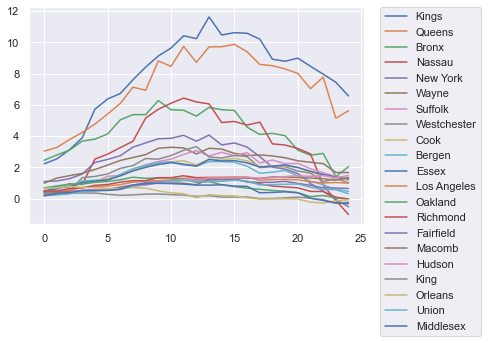

In [149]:
outcome_type = 'new_deaths'
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    if i > 20:
        break
    if i > -10:
        row = df.iloc[i]
        # If number of deaths greater than 10
        if max(row['deaths']) > 20:
            print(row['CountyName']) #+' in '+row['StateNameAbbreviation'])
            outcome_type = 'diff_new_deaths'
            plot_prediction(row,False,False)
#             outcome_type = 'deaths'
#             plot_prediction(row,False,False)
#             plt.show()



Kings
Queens
Bronx
Nassau
New York
Wayne
Suffolk
Westchester
Cook
Bergen
Essex
Los Angeles
Oakland
Richmond
Fairfield
Macomb
King
Hudson
Orleans
Union
Middlesex


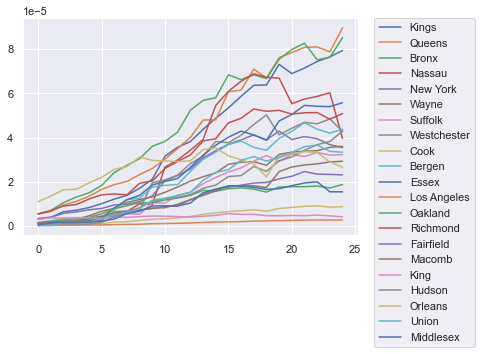

In [146]:
outcome_type = 'new_deaths'
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    if i > 20:
        break
    if i > -10:
        row = df.iloc[i]
        # If number of deaths greater than 10
        if max(row['deaths']) > 20:
            print(row['CountyName']) #+' in '+row['StateNameAbbreviation'])
            outcome_type = 'new_deaths'
            plot_prediction(row,True,False)
#             outcome_type = 'deaths'
#             plot_prediction(row,False,False)
#             plt.show()



Kings
Queens
Bronx
Nassau
New York
Wayne
Suffolk
Westchester
Cook
Bergen
Essex
Los Angeles
Oakland
Richmond
Fairfield
Macomb
Hudson
King
Orleans
Union
Middlesex


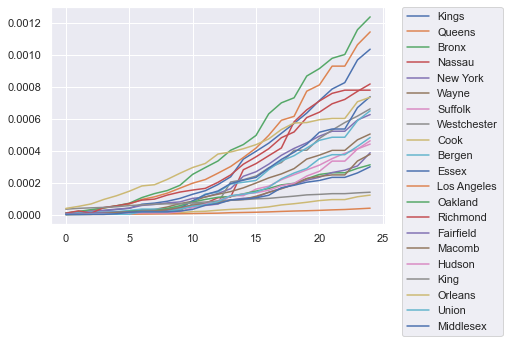

In [147]:

df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    if i > 20:
        break
    if i > -10:
        row = df.iloc[i]
        # If number of deaths greater than 10
        if max(row['deaths']) > 20:
            print(row['CountyName']) #+' in '+row['StateNameAbbreviation'])
            outcome_type = 'deaths'
            plot_prediction(row,True,False)
#             outcome_type = 'deaths'
#             plot_prediction(row,False,False)
#             plt.show()



Kings
Queens
Bronx
Nassau
New York
Wayne
Suffolk
Westchester
Cook
Bergen
Essex
Los Angeles
Oakland
Richmond
Fairfield
Macomb
King
Hudson
Orleans
Union
Middlesex


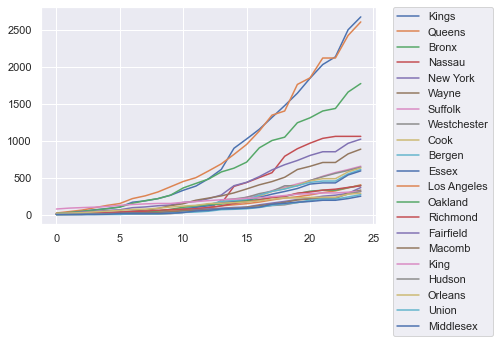

In [148]:

df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    if i > 20:
        break
    if i > -10:
        row = df.iloc[i]
        # If number of deaths greater than 10
        if max(row['deaths']) > 20:
            print(row['CountyName']) #+' in '+row['StateNameAbbreviation'])
            outcome_type = 'deaths'
            plot_prediction(row,False,False)
#             outcome_type = 'deaths'
#             plot_prediction(row,False,False)
#             plt.show()

